Finding best approach to LightGBM model in isolation trained on labelled data only.

After we have selected our approach to data preprocessing and missing feature imputation.

Here, we consider both QWK and MSE objective functions, as well as the usual combination of data augmentation, PCA, actigraphy data inclusion...

In [3]:
import numpy as np
import pandas as pd

import os

import polars as pl
from glob import glob
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow import keras
import random

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#from sklearn.impute import KNNImputer

#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import cohen_kappa_score

from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.svm import SVR

import lightgbm as lgb

from sklearn.model_selection import KFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

import matplotlib.pyplot as plt

In [4]:
train_data=pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test_data = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

In [5]:
INPUT_DIR = "/kaggle/input/child-mind-institute-problematic-internet-use/"

# Import aggregate fields from parquet files
# Modified code from rsakata: https://www.kaggle.com/code/rsakata/cmi-piu-16th-place-solution

files_train = glob(INPUT_DIR + "series_train.parquet/*")
#if IS_SUBMIT:
#    files += glob(INPUT_DIR + "series_test.parquet/*")

list_df_train = []
for file in tqdm(files_train):
    df_series = (
        pl.read_parquet(file)
        .with_columns(
            (
                (pl.col("relative_date_PCIAT") - pl.col("relative_date_PCIAT").min())*24
                + (pl.col("time_of_day") // int(1e9)) / 3600
            ).floor().cast(int).alias("total_hours")
        )
        .filter(pl.col("non-wear_flag") != 1)
        .filter(pl.col("step").count().over("total_hours") == 12 * 60)
        .group_by("total_hours").agg(
            pl.col("enmo").std().alias("enmo_std"),
            pl.col("anglez").std().alias("anglez_std"),
            pl.col("light").std().alias("light_std")
        )
        .with_columns(
            (pl.col("total_hours") % 24).alias("hour"),
            pl.lit(file.split("/")[-1][3:]).alias("id")
        )
    )
    list_df_train.append(df_series.to_pandas())

df_series = pd.concat(list_df_train)
df_series["enmo_std"] = np.log(df_series["enmo_std"] + 0.01)
df_series["anglez_std"] = np.log(df_series["anglez_std"] + 1)
df_series["light_std"] = np.log(df_series["light_std"] + 0.01)

df_agg_train = df_series.groupby("id")[["enmo_std", "anglez_std", "light_std"]].agg(["mean", "std"]).reset_index()
df_agg_train.columns = [cols[0] + "_" + cols[1] if cols[1] != "" else cols[0] for cols in df_agg_train.columns]
df_agg_train

  0%|          | 0/996 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,enmo_std_mean,enmo_std_std,anglez_std_mean,anglez_std_std,light_std_mean,light_std_std
0,00115b9f,-4.000377,NaN,1.989905,NaN,0.051475,NaN
1,001f3379,-3.514671,0.652348,3.236993,0.678888,0.774591,2.945807
2,00f332d1,-3.071176,0.927238,3.249122,0.463244,1.138379,2.939823
3,01085eb3,-2.902040,0.791255,3.389762,0.315061,1.054698,2.185839
4,012cadd8,-2.806918,1.171675,3.337322,0.388409,0.823770,3.350365
...,...,...,...,...,...,...,...
964,fe9c71d8,-3.116904,0.961804,3.037607,0.943554,-0.394200,2.742634
965,fecc07d6,-3.969482,0.981531,1.332831,1.428363,-0.438018,1.795653
966,ff18b749,-2.820076,0.937540,3.258458,0.417267,1.236652,3.341580
967,ffcd4dbd,-3.271800,0.827489,3.183395,0.629553,0.521227,2.665325


In [6]:
train_data2 = train_data.merge(df_agg_train, how="left", on="id")
train_data2.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,enmo_std_mean,enmo_std_std,anglez_std_mean,anglez_std_std,light_std_mean,light_std_std
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,NaN,Fall,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,64.0,Summer,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,54.0,Summer,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,45.0,Winter,0.0,1.0,-4.000377,NaN,1.989905,NaN,0.051475,NaN
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
files_test = glob(INPUT_DIR + "series_test.parquet/*")


list_df_test = []
for file in tqdm(files_test):
    df_series = (
        pl.read_parquet(file)
        .with_columns(
            (
                (pl.col("relative_date_PCIAT") - pl.col("relative_date_PCIAT").min())*24
                + (pl.col("time_of_day") // int(1e9)) / 3600
            ).floor().cast(int).alias("total_hours")
        )
        .filter(pl.col("non-wear_flag") != 1)
        .filter(pl.col("step").count().over("total_hours") == 12 * 60)
        .group_by("total_hours").agg(
            pl.col("enmo").std().alias("enmo_std"),
            pl.col("anglez").std().alias("anglez_std"),
            pl.col("light").std().alias("light_std")
        )
        .with_columns(
            (pl.col("total_hours") % 24).alias("hour"),
            pl.lit(file.split("/")[-1][3:]).alias("id")
        )
    )
    list_df_test.append(df_series.to_pandas())

df_series = pd.concat(list_df_test)
df_series["enmo_std"] = np.log(df_series["enmo_std"] + 0.01)
df_series["anglez_std"] = np.log(df_series["anglez_std"] + 1)
df_series["light_std"] = np.log(df_series["light_std"] + 0.01)

df_agg_test = df_series.groupby("id")[["enmo_std", "anglez_std", "light_std"]].agg(["mean", "std"]).reset_index()
df_agg_test.columns = [cols[0] + "_" + cols[1] if cols[1] != "" else cols[0] for cols in df_agg_test.columns]
df_agg_test

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,enmo_std_mean,enmo_std_std,anglez_std_mean,anglez_std_std,light_std_mean,light_std_std
0,00115b9f,-4.000377,NaN,1.989905,NaN,0.051475,NaN
1,001f3379,-3.514671,0.652348,3.236993,0.678888,0.774591,2.945807


In [8]:
test_data2 = test_data.merge(df_agg_test, how="left", on="id")
test_data2.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,enmo_std_mean,enmo_std_std,anglez_std_mean,anglez_std_std,light_std_mean,light_std_std
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,NaN,NaN,Fall,3.0,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,46.0,64.0,Summer,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,38.0,54.0,Summer,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,31.0,45.0,Winter,0.0,-4.000377,NaN,1.989905,NaN,0.051475,NaN
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
X_train = train_data2[['Basic_Demos-Age',
                      'Basic_Demos-Sex',
                      'CGAS-CGAS_Score',
                      'Physical-BMI',
                      'BIA-BIA_BMI',
                      'Physical-Waist_Circumference',
                      'Physical-Diastolic_BP',
                      'Physical-HeartRate',
                      'Physical-Systolic_BP',
                      'Fitness_Endurance-Max_Stage',
                      'Fitness_Endurance-Time_Mins',
                      'Fitness_Endurance-Time_Sec',
                      'FGC-FGC_CU_Zone',
                      'FGC-FGC_GSND_Zone',
                      'FGC-FGC_GSD_Zone',
                      'FGC-FGC_PU_Zone',
                      'FGC-FGC_SRL_Zone',
                      'FGC-FGC_SRR_Zone',
                      'FGC-FGC_TL_Zone',
                      'BIA-BIA_Activity_Level_num',
                      'BIA-BIA_BMC',
                      'BIA-BIA_BMR',
                      'BIA-BIA_DEE',
                      'BIA-BIA_ECW',
                      'BIA-BIA_FFM',
                      'BIA-BIA_FFMI',
                      'BIA-BIA_FMI',
                      'BIA-BIA_Fat',
                      'BIA-BIA_ICW',
                      'BIA-BIA_LDM',
                      'BIA-BIA_LST',
                      'BIA-BIA_SMM',
                      'BIA-BIA_TBW',
                      'PAQ_A-PAQ_A_Total',
                      'PAQ_C-PAQ_C_Total',
                      'SDS-SDS_Total_T',
                      'PreInt_EduHx-computerinternet_hoursday'
                       ,
                      'enmo_std_mean',
                      'enmo_std_std',
                      'anglez_std_mean',
                      'anglez_std_std',
                      'light_std_mean',
                      'light_std_std'
                      ]]

y_train = train_data2['PCIAT-PCIAT_Total']

X_test = test_data2[['Basic_Demos-Age',
                      'Basic_Demos-Sex',
                      'CGAS-CGAS_Score',
                      'Physical-BMI',
                      'BIA-BIA_BMI',
                      'Physical-Waist_Circumference',
                      'Physical-Diastolic_BP',
                      'Physical-HeartRate',
                      'Physical-Systolic_BP',
                      'Fitness_Endurance-Max_Stage',
                      'Fitness_Endurance-Time_Mins',
                      'Fitness_Endurance-Time_Sec',
                      'FGC-FGC_CU_Zone',
                      'FGC-FGC_GSND_Zone',
                      'FGC-FGC_GSD_Zone',
                      'FGC-FGC_PU_Zone',
                      'FGC-FGC_SRL_Zone',
                      'FGC-FGC_SRR_Zone',
                      'FGC-FGC_TL_Zone',
                      'BIA-BIA_Activity_Level_num',
                      'BIA-BIA_BMC',
                      'BIA-BIA_BMR',
                      'BIA-BIA_DEE',
                      'BIA-BIA_ECW',
                      'BIA-BIA_FFM',
                      'BIA-BIA_FFMI',
                      'BIA-BIA_FMI',
                      'BIA-BIA_Fat',
                      'BIA-BIA_ICW',
                      'BIA-BIA_LDM',
                      'BIA-BIA_LST',
                      'BIA-BIA_SMM',
                      'BIA-BIA_TBW',
                      'PAQ_A-PAQ_A_Total',
                      'PAQ_C-PAQ_C_Total',
                      'SDS-SDS_Total_T',
                      'PreInt_EduHx-computerinternet_hoursday'
                      ,
                      'enmo_std_mean',
                      'enmo_std_std',
                      'anglez_std_mean',
                      'anglez_std_std',
                      'light_std_mean',
                      'light_std_std'
                   ]]

In [10]:
# Add this only if we are not interested in the actigraph data

X_train = X_train.drop(columns=['enmo_std_mean',
                      'enmo_std_std',
                      'anglez_std_mean',
                      'anglez_std_std',
                      'light_std_mean',
                      'light_std_std'])

X_test = X_test.drop(columns=['enmo_std_mean',
                      'enmo_std_std',
                      'anglez_std_mean',
                      'anglez_std_std',
                      'light_std_mean',
                      'light_std_std'])


In [11]:
# Add calculated fields
X_train['Physical-BMI_Calc'] = X_train.apply(lambda row: row['Physical-BMI'] if row['Physical-BMI']==row['Physical-BMI'] else row['BIA-BIA_BMI'],axis=1)
X_train['Fitness_Endurance-Time_Sec_Calc'] = X_train.apply(lambda row: row['Fitness_Endurance-Time_Sec'] + (row['Fitness_Endurance-Time_Mins']*60), axis=1)
X_train['PAQ_Total'] = X_train.apply(lambda row: row['PAQ_A-PAQ_A_Total'] if row['PAQ_A-PAQ_A_Total']==row['PAQ_A-PAQ_A_Total'] else row['PAQ_C-PAQ_C_Total'],axis=1)


# Drop fields no longer needed
X_train = X_train.drop(columns=['PAQ_A-PAQ_A_Total','PAQ_C-PAQ_C_Total',
                     'Physical-BMI','BIA-BIA_BMI',
                     'Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec'])

# Remove outliers - may give warnings due to NaN value comparison
X_train.loc[X_train['CGAS-CGAS_Score']>=100.0,'CGAS-CGAS_Score'] = np.nan
X_train.loc[X_train['Physical-Systolic_BP']>=180.0,'Physical-Systolic_BP'] = np.nan
X_train.loc[X_train['Physical-Diastolic_BP']>=120.0,'Physical-Diastolic_BP'] = np.nan
X_train.loc[X_train['BIA-BIA_DEE']>=6000.0,'BIA-BIA_DEE'] = np.nan
X_train.loc[(X_train['BIA-BIA_BMC']<=0.0) | (X_train['BIA-BIA_BMC']>=16.0),'BIA-BIA_BMC'] = np.nan
X_train.loc[(X_train['BIA-BIA_BMR']<=0.0) | (X_train['BIA-BIA_BMR']>=2400.0),'BIA-BIA_BMR'] = np.nan
X_train.loc[(X_train['BIA-BIA_ECW']<=0.0) | (X_train['BIA-BIA_ECW']>=60.0),'BIA-BIA_ECW'] = np.nan
X_train.loc[(X_train['BIA-BIA_FFM']<=0.0) | (X_train['BIA-BIA_FFM']>=200.0),'BIA-BIA_FFM'] = np.nan
X_train.loc[(X_train['BIA-BIA_FFMI']<=0.0) | (X_train['BIA-BIA_FFMI']>=25.0),'BIA-BIA_FFMI'] = np.nan
X_train.loc[(X_train['BIA-BIA_FMI']<=0.0) | (X_train['BIA-BIA_FMI']>=25.0),'BIA-BIA_FMI'] = np.nan
X_train.loc[(X_train['BIA-BIA_Fat']<=8.0) | (X_train['BIA-BIA_Fat']>=60.0),'BIA-BIA_Fat'] = np.nan
X_train.loc[(X_train['BIA-BIA_ICW']<=0.0) | (X_train['BIA-BIA_ICW']>=80.0),'BIA-BIA_ICW'] = np.nan
X_train.loc[(X_train['BIA-BIA_LDM']<=0.0) | (X_train['BIA-BIA_LDM']>=60.0),'BIA-BIA_LDM'] = np.nan
X_train.loc[(X_train['BIA-BIA_LST']<=0.0) | (X_train['BIA-BIA_LST']>=150.0),'BIA-BIA_LST'] = np.nan
X_train.loc[(X_train['BIA-BIA_SMM']<=0.0) | (X_train['BIA-BIA_SMM']>=100.0),'BIA-BIA_SMM'] = np.nan
X_train.loc[(X_train['BIA-BIA_TBW']<=0.0) | (X_train['BIA-BIA_TBW']>=150.0),'BIA-BIA_TBW'] = np.nan

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pan

In [131]:
# Noting number of missing features
# Different weight approaches
features_missing_labelled = X_train.loc[y_train.notna()].isnull().sum(axis=1)/X_train.shape[1]
weights_labelled = 1 - features_missing_labelled
weights_labelled.shape

features_missing_labelled2 = X_train.loc[y_train.notna()].isnull().sum(axis=1)
weights_labelled2 = 1 * ((0.95)**features_missing_labelled2)

weights_labelled3 = np.exp((-2)*features_missing_labelled)

weights_labelled4 = features_missing_labelled.apply(lambda row: 0 if row>0.8 else 1)

In [118]:
# Use "gate" weights weights_labelled4 to modify other weights
# i.e., keep the same but drop to zero below a threshold
weights_labelled14 = weights_labelled*weights_labelled4
weights_labelled24 = weights_labelled2*weights_labelled4
weights_labelled34 = weights_labelled3*weights_labelled4

In [13]:
#MICE
iter_imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_fimpute = pd.DataFrame(iter_imputer.fit_transform(X_train), columns = X_train.columns)
X_train_fimpute.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Physical-BMI_Calc,Fitness_Endurance-Time_Sec_Calc,PAQ_Total
count,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,...,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000
mean,10.433586,0.372727,64.818333,26.974426,69.403169,81.519388,116.805724,4.974030,0.480343,1.849340,...,31.365620,18.066786,63.749033,31.477562,50.138601,57.881433,1.073783,19.374281,468.721596,2.537644
std,3.574648,0.483591,9.805847,4.770198,11.011761,12.021297,14.228392,0.935016,0.389401,0.346190,...,7.099089,5.021442,18.068723,10.250418,13.839926,10.737030,1.022870,4.520383,89.856124,0.653839
min,5.000000,0.000000,-23.164848,4.967968,0.000000,27.000000,0.000000,0.000000,-0.172314,-1.772461,...,14.489000,4.635810,23.620100,4.655730,20.589200,38.000000,-0.278039,0.000000,5.000000,0.580000
25%,8.000000,0.000000,60.000000,24.000000,64.000000,74.477905,109.000000,4.865373,0.000000,1.766934,...,28.665877,16.394825,56.747700,27.190300,44.819225,51.000000,0.000000,16.485531,450.588533,2.150000
50%,10.000000,0.000000,64.765647,26.137767,69.000000,81.485263,115.604541,4.973003,0.485209,1.872826,...,31.347850,18.058831,63.734357,30.792761,50.135566,57.770114,1.000000,18.589876,469.207062,2.567600
75%,13.000000,1.000000,70.000000,29.035486,73.000000,87.000000,122.000000,5.081351,1.000000,2.000000,...,32.689980,18.232694,63.917531,33.007960,50.147145,60.000000,2.000000,21.015855,487.416029,2.886524
max,22.000000,1.000000,95.000000,56.944995,119.000000,138.000000,179.000000,28.000000,1.129295,3.000000,...,86.587576,52.527500,188.145195,111.835760,146.075000,100.000000,3.019947,59.132048,2154.275208,4.790000


In [14]:
# Clip imputed values to original max and min
for column in X_train_fimpute.columns:
    max_val = np.max(X_train[column])
    min_val = np.min(X_train[column])
    X_train_fimpute.loc[X_train_fimpute[column]>max_val,column] = max_val
    X_train_fimpute.loc[X_train_fimpute[column]<min_val, column] = min_val

X_train_fimpute.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Physical-BMI_Calc,Fitness_Endurance-Time_Sec_Calc,PAQ_Total
count,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,...,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000,3960.000000
mean,10.433586,0.372727,64.830496,26.998653,69.403169,81.519388,116.805724,4.974030,0.480419,1.850041,...,31.363446,18.066786,63.672368,31.469455,50.138601,57.881433,1.073848,19.374281,468.480617,2.537644
std,3.574648,0.483591,9.726236,4.692416,11.011761,12.021297,14.228392,0.935016,0.389164,0.341634,...,7.083396,5.021442,17.644465,10.193244,13.839926,10.737030,1.022777,4.520383,86.553527,0.653839
min,5.000000,0.000000,25.000000,18.000000,0.000000,27.000000,0.000000,0.000000,0.000000,1.000000,...,14.489000,4.635810,23.620100,4.655730,20.589200,38.000000,0.000000,0.000000,5.000000,0.580000
25%,8.000000,0.000000,60.000000,24.000000,64.000000,74.477905,109.000000,4.865373,0.000000,1.766934,...,28.665877,16.394825,56.747700,27.190300,44.819225,51.000000,0.000000,16.485531,450.588533,2.150000
50%,10.000000,0.000000,64.765647,26.137767,69.000000,81.485263,115.604541,4.973003,0.485209,1.872826,...,31.347850,18.058831,63.734357,30.792761,50.135566,57.770114,1.000000,18.589876,469.207062,2.567600
75%,13.000000,1.000000,70.000000,29.035486,73.000000,87.000000,122.000000,5.081351,1.000000,2.000000,...,32.689980,18.232694,63.917531,33.007960,50.147145,60.000000,2.000000,21.015855,487.416029,2.886524
max,22.000000,1.000000,95.000000,50.000000,119.000000,138.000000,179.000000,28.000000,1.000000,3.000000,...,79.473800,52.527500,149.830000,97.923100,146.075000,100.000000,3.000000,59.132048,1200.000000,4.790000


In [15]:
# standardise data
scaler = StandardScaler()                  

X_train_fimpute[X_train_fimpute.columns] = scaler.fit_transform(X_train_fimpute[X_train_fimpute.columns])
X_train_fimpute.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Physical-BMI_Calc,Fitness_Endurance-Time_Sec_Calc,PAQ_Total
count,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,...,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03,3.960000e+03
mean,-1.928872e-16,-5.831474e-17,8.343494e-16,5.921189e-17,2.866394e-16,4.893953e-16,-3.545985e-16,6.948426e-16,-1.282924e-16,1.058637e-16,...,-3.184882e-16,-1.004808e-16,1.040694e-16,-4.135861e-16,1.964758e-16,-1.821214e-16,-5.741759e-17,9.796877e-16,4.831152e-16,-1.578984e-16
std,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,...,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00,1.000126e+00
min,-1.520226e+00,-7.708456e-01,-4.095678e+00,-1.917944e+00,-6.303437e+00,-4.535806e+00,-8.210378e+00,-5.320400e+00,-1.234646e+00,-2.488480e+00,...,-2.382555e+00,-2.675063e+00,-2.270249e+00,-2.630871e+00,-2.135353e+00,-1.851904e+00,-1.050066e+00,-4.286523e+00,-5.355520e+00,-2.994455e+00
25%,-6.808763e-01,-7.708456e-01,-4.967087e-01,-6.391231e-01,-4.907346e-01,-5.858247e-01,-5.486713e-01,-1.162227e-01,-1.234646e+00,-2.432958e-01,...,-3.808780e-01,-3.330064e-01,-3.925051e-01,-4.198561e-01,-3.843986e-01,-6.409875e-01,-1.050066e+00,-6.391307e-01,-2.067431e-01,-5.929487e-01
50%,-1.213100e-01,-7.708456e-01,-6.668295e-03,-1.834866e-01,-3.661725e-02,-2.839099e-03,-8.443218e-02,-1.098129e-03,1.230976e-02,6.670247e-02,...,-2.202046e-03,-1.584385e-03,3.513687e-03,-6.639494e-02,-2.193295e-04,-1.036914e-02,-7.221268e-02,-1.735482e-01,8.394070e-03,4.582149e-02
75%,7.180394e-01,1.297277e+00,5.315681e-01,4.341239e-01,3.266766e-01,4.559661e-01,3.651103e-01,1.147947e-01,1.335289e+00,4.390017e-01,...,1.872974e-01,3.304415e-02,1.389639e-02,1.509529e-01,6.173593e-04,1.973390e-01,9.056408e-01,3.631950e-01,2.187987e-01,5.336544e-01
max,3.236088e+00,1.297277e+00,3.102260e+00,4.902432e+00,4.504556e+00,4.698973e+00,4.371691e+00,2.462940e+01,1.335289e+00,3.366483e+00,...,6.792848e+00,6.863580e+00,4.883600e+00,6.520205e+00,6.932733e+00,3.923235e+00,1.883494e+00,8.796331e+00,8.452709e+00,3.445252e+00


In [16]:
# Repeat the above for X_test

# Add calculated fields
X_test['Physical-BMI_Calc'] = X_test.apply(lambda row: row['Physical-BMI'] if row['Physical-BMI']==row['Physical-BMI'] else row['BIA-BIA_BMI'],axis=1)
X_test['Fitness_Endurance-Time_Sec_Calc'] = X_test.apply(lambda row: row['Fitness_Endurance-Time_Sec'] + (row['Fitness_Endurance-Time_Mins']*60), axis=1)
X_test['PAQ_Total'] = X_test.apply(lambda row: row['PAQ_A-PAQ_A_Total'] if row['PAQ_A-PAQ_A_Total']==row['PAQ_A-PAQ_A_Total'] else row['PAQ_C-PAQ_C_Total'],axis=1)

# Drop fields no longer needed
X_test = X_test.drop(columns=['PAQ_A-PAQ_A_Total','PAQ_C-PAQ_C_Total',
                     'Physical-BMI','BIA-BIA_BMI',
                     'Fitness_Endurance-Time_Mins','Fitness_Endurance-Time_Sec'])

# Remove outliers
X_test.loc[X_test['CGAS-CGAS_Score']>=100.0,'CGAS-CGAS_Score'] = np.nan
X_test.loc[X_test['Physical-Systolic_BP']>=180.0,'Physical-Systolic_BP'] = np.nan
X_test.loc[X_test['Physical-Diastolic_BP']>=120.0,'Physical-Diastolic_BP'] = np.nan
X_test.loc[X_test['BIA-BIA_DEE']>=6000.0,'BIA-BIA_DEE'] = np.nan
X_test.loc[(X_test['BIA-BIA_BMC']<=0.0) | (X_test['BIA-BIA_BMC']>=16.0),'BIA-BIA_BMC'] = np.nan
X_test.loc[(X_test['BIA-BIA_BMR']<=0.0) | (X_test['BIA-BIA_BMR']>=2400.0),'BIA-BIA_BMR'] = np.nan
X_test.loc[(X_test['BIA-BIA_ECW']<=0.0) | (X_test['BIA-BIA_ECW']>=60.0),'BIA-BIA_ECW'] = np.nan
X_test.loc[(X_test['BIA-BIA_FFM']<=0.0) | (X_test['BIA-BIA_FFM']>=200.0),'BIA-BIA_FFM'] = np.nan
X_test.loc[(X_test['BIA-BIA_FFMI']<=0.0) | (X_test['BIA-BIA_FFMI']>=25.0),'BIA-BIA_FFMI'] = np.nan
X_test.loc[(X_test['BIA-BIA_FMI']<=0.0) | (X_test['BIA-BIA_FMI']>=25.0),'BIA-BIA_FMI'] = np.nan
X_test.loc[(X_test['BIA-BIA_Fat']<=8.0) | (X_test['BIA-BIA_Fat']>=60.0),'BIA-BIA_Fat'] = np.nan
X_test.loc[(X_test['BIA-BIA_ICW']<=0.0) | (X_test['BIA-BIA_ICW']>=80.0),'BIA-BIA_ICW'] = np.nan
X_test.loc[(X_test['BIA-BIA_LDM']<=0.0) | (X_test['BIA-BIA_LDM']>=60.0),'BIA-BIA_LDM'] = np.nan
X_test.loc[(X_test['BIA-BIA_LST']<=0.0) | (X_test['BIA-BIA_LST']>=150.0),'BIA-BIA_LST'] = np.nan
X_test.loc[(X_test['BIA-BIA_SMM']<=0.0) | (X_test['BIA-BIA_SMM']>=100.0),'BIA-BIA_SMM'] = np.nan
X_test.loc[(X_test['BIA-BIA_TBW']<=0.0) | (X_test['BIA-BIA_TBW']>=150.0),'BIA-BIA_TBW'] = np.nan

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pan

In [17]:
# Imputation
X_test_fimpute = pd.DataFrame(iter_imputer.transform(X_test), columns = X_test.columns)

# Clipping
for column in X_test_fimpute.columns:
    max_val = np.max(X_train[column])
    min_val = np.min(X_train[column])
    X_test_fimpute.loc[X_test_fimpute[column]>max_val,column] = max_val
    X_test_fimpute.loc[X_test_fimpute[column]<min_val, column] = min_val

# Scaling
X_test_fimpute[X_test_fimpute.columns] = scaler.transform(X_test_fimpute[X_test_fimpute.columns])

X_test_fimpute.describe()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Max_Stage,FGC-FGC_CU_Zone,FGC-FGC_GSND_Zone,...,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,Physical-BMI_Calc,Fitness_Endurance-Time_Sec_Calc,PAQ_Total
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.088527,0.056403,-0.045878,0.062078,-0.054532,-0.024661,0.096746,-0.099940,-0.092855,-0.200220,...,-0.201746,-0.212473,-0.149911,-0.186412,-0.143597,-0.248715,0.397885,0.159731,-0.138408,-0.321770
std,1.042416,1.039489,0.801382,0.834814,0.728397,0.630397,1.095310,0.609633,1.064675,0.889571,...,0.502229,0.550313,0.534173,0.543306,0.553989,0.532311,1.029493,0.885501,0.532544,1.215554
min,-1.520226,-0.770846,-1.524985,-1.917944,-1.126499,-0.958369,-1.532744,-1.982619,-1.234646,-2.488480,...,-1.458277,-1.826683,-1.403148,-1.575630,-1.668095,-1.665609,-1.050066,-1.181175,-1.577034,-2.290829
25%,-0.401093,-0.770846,-0.398350,-0.639123,-0.626970,-0.479991,-0.323267,-0.117459,-1.234646,-0.271331,...,-0.353243,-0.152373,-0.072266,-0.321185,-0.053025,-0.384832,-0.316676,-0.484882,-0.194965,-0.793832
50%,-0.121310,-0.770846,0.053470,0.186887,0.013374,-0.096654,0.013656,-0.010525,-0.226210,-0.084494,...,-0.172488,-0.012274,0.001130,-0.057763,-0.000024,-0.036684,0.905641,0.059206,-0.060168,-0.247980
75%,0.508202,1.297277,0.442934,0.601291,0.157655,0.349697,0.359988,0.109218,1.335289,0.310673,...,0.143634,0.007697,0.007959,0.164499,0.000693,0.043558,0.934083,0.438107,0.054260,0.197347
max,2.396738,1.297277,1.559845,1.827302,2.099974,1.287928,3.247037,1.097415,1.335289,1.002942,...,0.662725,0.564693,0.908379,0.466421,0.938555,0.569929,1.883494,2.371861,1.253942,2.405110


In [18]:
X_train_labelled = X_train_fimpute.loc[y_train.notna()]
y_train_labelled = y_train[y_train.notna()]
print("Size of labelled train data set is: ", (X_train_labelled.shape, y_train_labelled.shape))

Size of labelled train data set is:  ((2736, 34), (2736,))


In [19]:
# Since we are not using the unlabelled data in this notebook, we can drop the indices
# This will help us prevent any accidents when doing cross-validation when we split by index, don't have to think about loc vs iloc etc.

X_train_labelled = X_train_labelled.reset_index(drop=True)
y_train_labelled = y_train_labelled.reset_index(drop=True)

In [20]:
weights_labelled = weights_labelled.reset_index(drop=True)
weights_labelled2 = weights_labelled2.reset_index(drop=True)
weights_labelled3 = weights_labelled3.reset_index(drop=True)
weights_labelled4 = weights_labelled4.reset_index(drop=True)

In [21]:
# X datasets - X_train_labelled, X_train_labelled_aug1a, X_train_labelled_aug1b, X_train_labelled_aug2a, X_train_labelled_aug2b
# aug1/aug2 - augment once or twice
# a/b - 0.1 noise multiplier, 0.15 noise multiplier

# Augmented data

# Get standard deviations of each column in X and y
std_X = np.std(X_train_labelled, axis=0)
std_y = np.std(y_train_labelled, axis=0)

# Create augmented datasets

X_noise_multiplier=0.1
y_noise_multiplier=0.1

# Deliberately not doing this in a for loop because we will not augment more than twice
# For ease of understanding the datasets being created
# And we may choose to add different noisiness to each augmentation
X_train_labelled_noisy = X_train_labelled + (X_noise_multiplier * np.random.normal(0, std_X, X_train_labelled.shape))
y_train_labelled_noisy = y_train_labelled + (y_noise_multiplier * np.random.normal(0, std_y, y_train_labelled.shape))

X_train_labelled_aug1a = pd.concat([X_train_labelled,X_train_labelled_noisy], ignore_index=True)
y_train_labelled_aug1a = pd.concat([y_train_labelled,y_train_labelled_noisy], ignore_index=True)
print(X_train_labelled_aug1a.shape, y_train_labelled_aug1a.shape)

#repeat
X_train_labelled_noisy = X_train_labelled + (X_noise_multiplier * np.random.normal(0, std_X, X_train_labelled.shape))
y_train_labelled_noisy = y_train_labelled + (y_noise_multiplier * np.random.normal(0, std_y, y_train_labelled.shape))

X_train_labelled_aug2a = pd.concat([X_train_labelled_aug1a,X_train_labelled_noisy], ignore_index=True)
y_train_labelled_aug2a = pd.concat([y_train_labelled_aug1a,y_train_labelled_noisy], ignore_index=True)
print(X_train_labelled_aug2a.shape, y_train_labelled_aug2a.shape)


# Increased noise multiplier
X_noise_multiplier=0.15
y_noise_multiplier=0.15

X_train_labelled_noisy = X_train_labelled + (X_noise_multiplier * np.random.normal(0, std_X, X_train_labelled.shape))
y_train_labelled_noisy = y_train_labelled + (y_noise_multiplier * np.random.normal(0, std_y, y_train_labelled.shape))

X_train_labelled_aug1b = pd.concat([X_train_labelled,X_train_labelled_noisy], ignore_index=True)
y_train_labelled_aug1b = pd.concat([y_train_labelled,y_train_labelled_noisy], ignore_index=True)
print(X_train_labelled_aug1b.shape, y_train_labelled_aug1b.shape)

#repeat
X_train_labelled_noisy = X_train_labelled + (X_noise_multiplier * np.random.normal(0, std_X, X_train_labelled.shape))
y_train_labelled_noisy = y_train_labelled + (y_noise_multiplier * np.random.normal(0, std_y, y_train_labelled.shape))

X_train_labelled_aug2b = pd.concat([X_train_labelled_aug1b,X_train_labelled_noisy], ignore_index=True)
y_train_labelled_aug2b = pd.concat([y_train_labelled_aug1b,y_train_labelled_noisy], ignore_index=True)
print(X_train_labelled_aug2b.shape, y_train_labelled_aug2b.shape)


X_noise_multiplier=0.2
y_noise_multiplier=0.2

X_train_labelled_noisy = X_train_labelled + (X_noise_multiplier * np.random.normal(0, std_X, X_train_labelled.shape))
y_train_labelled_noisy = y_train_labelled + (y_noise_multiplier * np.random.normal(0, std_y, y_train_labelled.shape))

X_train_labelled_aug1c = pd.concat([X_train_labelled,X_train_labelled_noisy], ignore_index=True)
y_train_labelled_aug1c = pd.concat([y_train_labelled,y_train_labelled_noisy], ignore_index=True)
print(X_train_labelled_aug1c.shape, y_train_labelled_aug1c.shape)

#repeat
X_train_labelled_noisy = X_train_labelled + (X_noise_multiplier * np.random.normal(0, std_X, X_train_labelled.shape))
y_train_labelled_noisy = y_train_labelled + (y_noise_multiplier * np.random.normal(0, std_y, y_train_labelled.shape))

X_train_labelled_aug2c = pd.concat([X_train_labelled_aug1c,X_train_labelled_noisy], ignore_index=True)
y_train_labelled_aug2c = pd.concat([y_train_labelled_aug1c,y_train_labelled_noisy], ignore_index=True)
print(X_train_labelled_aug2c.shape, y_train_labelled_aug2c.shape)


(5472, 34) (5472,)
(8208, 34) (8208,)
(5472, 34) (5472,)
(8208, 34) (8208,)
(5472, 34) (5472,)
(8208, 34) (8208,)


In [22]:
# Weights. We already have defined weights_labelled, weights_labelled2, weights_labelled3
# Just need to augment

weights_labelled_aug1 = pd.concat([weights_labelled, weights_labelled], ignore_index=True)
weights_labelled_aug2 = pd.concat([weights_labelled_aug1, weights_labelled], ignore_index=True)
print(weights_labelled_aug1.shape, weights_labelled_aug2.shape)

weights_labelled2_aug1 = pd.concat([weights_labelled2, weights_labelled2], ignore_index=True)
weights_labelled2_aug2 = pd.concat([weights_labelled2_aug1, weights_labelled2], ignore_index=True)
print(weights_labelled2_aug1.shape, weights_labelled2_aug2.shape)

weights_labelled3_aug1 = pd.concat([weights_labelled3, weights_labelled3], ignore_index=True)
weights_labelled3_aug2 = pd.concat([weights_labelled3_aug1, weights_labelled3], ignore_index=True)
print(weights_labelled3_aug1.shape, weights_labelled3_aug2.shape)

weights_labelled4_aug1 = pd.concat([weights_labelled4, weights_labelled4], ignore_index=True)
weights_labelled4_aug2 = pd.concat([weights_labelled4_aug1, weights_labelled4], ignore_index=True)
print(weights_labelled4_aug1.shape, weights_labelled4_aug2.shape)

(5472,) (8208,)
(5472,) (8208,)
(5472,) (8208,)


In [119]:
weights_labelled14_aug1 = pd.concat([weights_labelled14, weights_labelled14], ignore_index=True)
weights_labelled14_aug2 = pd.concat([weights_labelled14_aug1, weights_labelled14], ignore_index=True)
print(weights_labelled14_aug1.shape, weights_labelled14_aug2.shape)

weights_labelled24_aug1 = pd.concat([weights_labelled24, weights_labelled24], ignore_index=True)
weights_labelled24_aug2 = pd.concat([weights_labelled24_aug1, weights_labelled24], ignore_index=True)
print(weights_labelled24_aug1.shape, weights_labelled24_aug2.shape)

weights_labelled34_aug1 = pd.concat([weights_labelled34, weights_labelled34], ignore_index=True)
weights_labelled34_aug2 = pd.concat([weights_labelled34_aug1, weights_labelled34], ignore_index=True)
print(weights_labelled34_aug1.shape, weights_labelled34_aug2.shape)

(5472,) (8208,)
(5472,) (8208,)
(5472,) (8208,)


In [23]:
y_train_labelled_sii = y_train_labelled.copy()
y_train_labelled_sii.name='sii'
y_train_labelled_sii = y_train_labelled_sii.apply(lambda row: 0 if row<=30 else 
                             (1 if row<50 else (
                                2 if row<80 else (3)
                            )))

y_train_labelled_sii_aug1 = pd.concat([y_train_labelled_sii, y_train_labelled_sii], ignore_index=True)
y_train_labelled_sii_aug2 = pd.concat([y_train_labelled_sii_aug1, y_train_labelled_sii], ignore_index=True)

# Not using our alternative binned target, as it did not improve results

[3.11764706 1.17647059 1.23529412 3.29411765]
[3.1109, 1.1709, 1.2309, 3.2908999999999997]


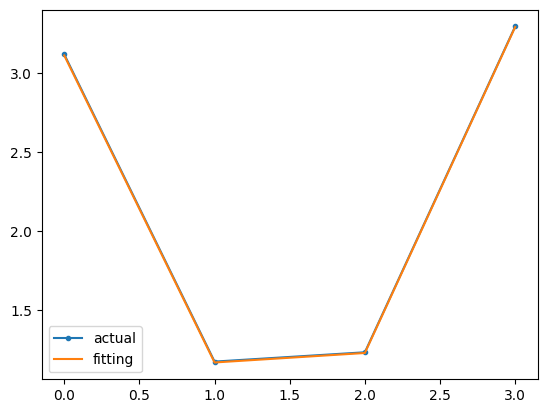

In [24]:
# Custom qwk metric and loss function for pciat_sii
#Modified from https://medium.com/@nlztrk/quadratic-weighted-kappa-qwk-metric-and-how-to-optimize-it-062cc9121baa
y = np.array([0,1,2,1,1,2,3,3,2,3,2,1,2,1,0,1,0])

c = 1.47
d = 0.95

g = np.zeros(4)
for i in range(4):
    g[i] = ((y - i)**2).mean()
    #g[i] = i

print(g)
h = [(x-c)**2 + d for x in [0,1,2,3]]
print(h)

plt.plot([0,1,2,3], g, marker=".", label="actual")
plt.plot([0,1,2,3], [(x-c)**2 + d for x in [0,1,2,3]], label="fitting")
plt.legend()
plt.show()

In [93]:
# Metric for XGB - not used

def quadratic_weighted_kappa_sii(y_true, y_pred):
    if isinstance(y_pred, xgb.QuantileDMatrix):
        # XGB
        y_true, y_pred = y_pred, y_true

        y_true = (y_true.get_label() + c).round()
        y_pred = (y_pred + c).clip(0, 3).round()
        qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        return 'QWK', qwk

    else:
        # For LightGBM
        y_true = y_true + c
        y_pred = (y_pred + c).clip(0, 3).round()
        qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
        return 'QWK', qwk, True


# Objective function for both XGB and LGB
def qwk_obj_sii(y_true, y_pred, sample_weight=None):
    labels = y_true + c
    preds = y_pred + c
    preds = preds.clip(0, 3)
    f = 1/2*np.sum((preds-labels)**2)
    g = 1/2*np.sum((preds-c)**2+d)
    df = preds - labels
    dg = preds - c

    if sample_weight is not None:
        grad = (df/g - f*dg/g**2)*len(labels)*sample_weight
        hess = np.ones(len(labels))*sample_weight
    else:
        grad = (df/g - f*dg/g**2)*len(labels)
        hess = np.ones(len(labels))

    #grad = (df/g - f*dg/g**2)*len(labels)
    #hess = np.ones(len(labels))
    
    return grad, hess

# V1: Regression on PCIAT

In [40]:
#lgbm_model = lgb.LGBMRegressor(objective='regression', metric='l2', boosting_type='gbdt',
#                              num_leaves=31, learning_rate=0.01, n_estimators=300,
#                              subsample=0.8, colsample_bytree=0.8)

In [41]:
#lgbm_model.fit(X_train_labelled,y_train_labelled)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7735
[LightGBM] [Info] Number of data points in the train set: 2736, number of used features: 34
[LightGBM] [Info] Start training from score 27.896199


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.01, metric='l2',
              n_estimators=300, objective='regression', subsample=0.8)

# V2: QWK on sii

In [94]:
lgbm_model = lgb.LGBMRegressor(objective=qwk_obj_sii, metric='l2', boosting_type='gbdt',
                              num_leaves=31, learning_rate=0.01, n_estimators=300,
                              subsample=0.8, colsample_bytree=0.8)

In [67]:
weights_labelled.head(10)

0    0.705882
1    0.823529
2    0.558824
3    0.911765
4    0.882353
5    0.794118
6    0.176471
7    0.882353
8    0.470588
9    0.411765
dtype: float64

In [68]:
weights_labelled2.head(10)

0    0.598737
1    0.735092
2    0.463291
3    0.857375
4    0.814506
5    0.698337
6    0.237827
7    0.814506
8    0.397214
9    0.358486
dtype: float64

In [71]:
weights_labelled3.head(10)

0    0.555306
1    0.702619
2    0.413808
3    0.838223
4    0.790338
5    0.662480
6    0.192616
7    0.790338
8    0.346864
9    0.308365
dtype: float64

In [72]:
type(weights_labelled2)

pandas.core.series.Series

In [140]:
lgbm_model.fit(X_train_labelled_aug2b,y_train_labelled_sii_aug2, sample_weight=weights_labelled3_aug2)

[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 8208, number of used features: 34
[LightGBM] [Info] Using self-defined objective function


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.01, metric='l2',
              n_estimators=300,
              objective=<function qwk_obj_sii at 0x7836201a63b0>,
              subsample=0.8)

In [141]:
y_test = test_data[['id']]

In [142]:
y_test['Prediction_lgbm'] = lgbm_model.predict(X_test_fimpute)
y_test.head()

<ipython-input-142-27cd549938d4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Prediction_lgbm'] = lgbm_model.predict(X_test_fimpute)


,id,Prediction_lgbm
0,00008ff9,1.239885
1,000fd460,0.318513
2,00105258,0.624868
3,00115b9f,0.355977
4,0016bb22,1.131967


In [136]:
#y_test['Prediction_lgbm'] = y_test.apply(lambda row: 0 if row['Prediction_lgbm']<=30 else 
#                             (1 if row['Prediction_lgbm']<50 else (
#                                2 if row['Prediction_lgbm']<80 else (3)
#                            )), axis=1)
y_test['Prediction_lgbm'] = np.round(y_test['Prediction_lgbm'])
y_test.head()

<ipython-input-136-48b700127129>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Prediction_lgbm'] = np.round(y_test['Prediction_lgbm'])


,id,Prediction_lgbm
0,00008ff9,1.0
1,000fd460,0.0
2,00105258,1.0
3,00115b9f,0.0
4,0016bb22,1.0


In [104]:
y_test['sii'] = y_test['Prediction_lgbm']

y_test.head()

<ipython-input-104-e854fe31688f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['sii'] = y_test['Prediction_lgbm']


,id,Prediction_lgbm,sii
0,00008ff9,1.0,1.0
1,000fd460,0.0,0.0
2,00105258,1.0,1.0
3,00115b9f,0.0,0.0
4,0016bb22,1.0,1.0


In [50]:
solution = y_test[['id','sii']]
solution.to_csv("submission.csv", index=False)